In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
data_dir = './training-data'
BATCH_SIZE = 32
img_height = 180
img_width = 180

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 65 files belonging to 7 classes.
Using 52 files for training.


In [4]:
class_names = train_dataset.class_names

In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE)

Found 65 files belonging to 7 classes.
Using 13 files for validation.


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [9]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [10]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [13]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
2/2 [==============================] - 1s 311ms/step - loss: 2.4903 - accuracy: 0.1731 - val_loss: 2.7997 - val_accuracy: 0.2308
Epoch 2/25
2/2 [==============================] - 0s 240ms/step - loss: 2.2606 - accuracy: 0.2692 - val_loss: 2.1706 - val_accuracy: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 156ms/step - loss: 1.9214 - accuracy: 0.2500 - val_loss: 1.9451 - val_accuracy: 0.2308
Epoch 4/25
2/2 [==============================] - 0s 154ms/step - loss: 1.8839 - accuracy: 0.2115 - val_loss: 1.8770 - val_accuracy: 0.2308
Epoch 5/25
2/2 [==============================] - 0s 238ms/step - loss: 1.8622 - accuracy: 0.2115 - val_loss: 1.8427 - val_accuracy: 0.2308
Epoch 6/25
2/2 [==============================] - 0s 143ms/step - loss: 1.8453 - accuracy: 0.2500 - val_loss: 1.8229 - val_accuracy: 0.2308
Epoch 7/25
2/2 [==============================] - 0s 151ms/step - loss: 1.8240 - accuracy: 0.3077 - val_loss: 1.8254 - val_accuracy: 0.2308
Epoch 8/25
2/2 [

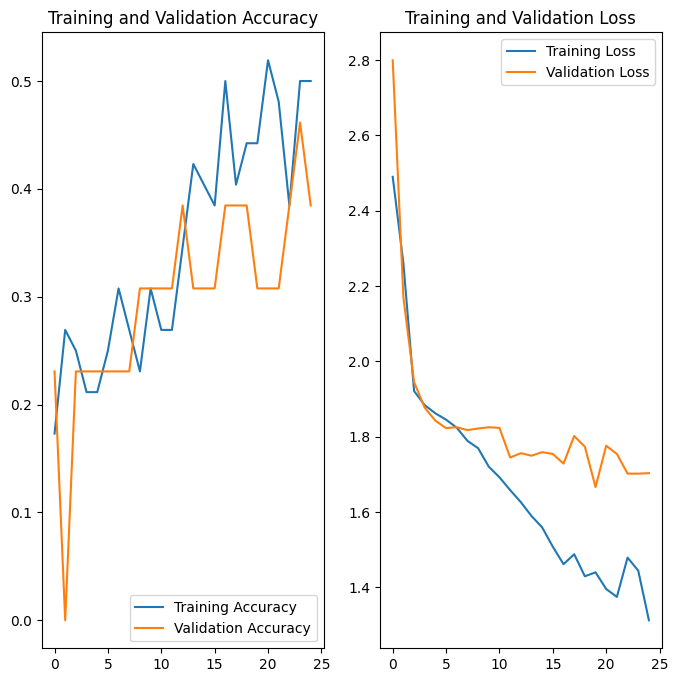

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
fullPath = os.path.abspath("./testimage2.jpeg")  # or similar, depending on your scenario
image_path = tf.keras.utils.get_file('./testimage2.jpeg', 'file://'+fullPath)

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


In [ ]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [16]:
model.save('bristol-model.h5')

/Users/luka/.pyenv/versions/3.8.16/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
loaded_model = tf.keras.models.load_model('bristol-model.h5')


In [26]:
loaded_pred = loaded_model.predict(img_array)
loaded_score = tf.nn.softmax(loaded_pred[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(loaded_score)], 100 * np.max(loaded_score))
)

1/1 [==============================] - 0s 48ms/step
This image most likely belongs to type-1 with a 36.98 percent confidence.
